# Working on the AI Agent with some community tools

In [ ]:
!pip install langgraph langsmith langchain langchain_groq langchain_community wikipedia arxiv

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")

os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_Agent"

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

## Setting up tools

In [4]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)

arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wiki_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

### Example of Wiki tool usage

In [5]:
wiki_tool.invoke("Who is Zeng Laishun?")

'Page: Zeng Laishun\nSummary: Zeng Laishun (13 September 1826 – 2 June 1895) was a Chinese interpreter, businessman, and educator. He was among the first Chinese people to study at a foreign college. Born in Singapore to a Teochew father and a Malay mother, he was orphaned as a young child. He was edu'

In [6]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

## Building the graph now

In [7]:
from langchain_groq import ChatGroq

llm = ChatGroq(api_key=groq_api_key, model="Gemma2-9b-It")

In [8]:
tools = [arxiv_tool, wiki_tool]

In [9]:
llm = llm.bind_tools(tools=tools)

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [11]:
def chatbot(state: State) -> str:
    return {"messages": [llm.invoke(state["messages"])]}

In [12]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [13]:
graph = graph_builder.compile()

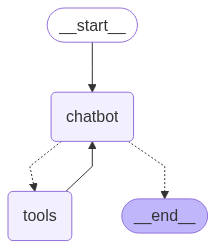

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
user_inputs = [
    # "What is the latest research on quantum computing?",
    "Who is Zeng Laishun?",
    "What is the paper 'Attention is all you need' about?",
]

for user_input in user_inputs:
    events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")

    for event in events:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who is Zeng Laishun?
================================== Ai Message ==================================
Tool Calls:
  wikipedia (call_x2wn)
 Call ID: call_x2wn
  Args:
    query: Zeng Laishun
================================= Tool Message =================================
Name: wikipedia

Page: Zeng Laishun
Summary: Zeng Laishun (13 September 1826 – 2 June 1895) was a Chinese interpreter, businessman, and educator. He was among the first Chinese people to study at a foreign college. Born in Singapore to a Teochew father and a Malay mother, he was orphaned as a young child. He was edu
================================== Ai Message ==================================

Zeng Laishun (13 September 1826 – 2 June 1895) was a Chinese interpreter, businessman, and educator. He was among the first Chinese people to study at a foreign college. Born in Singapore to a Teochew father and a Malay mother, he was orphaned as 